# Introduction 
This notebook uses 3 unsupervised clustering techniques to identify similarities or groupings between 6 different classical works of fiction.  It then builds 4 supervised learning models that predict the classification of a random sentence from each of the 6 corpora.  The 6 corpora are:  

- Julius Caesar by William Shakespeare
- Dracula by Bram Stoker
- The Iliad by Homer 
- Peter Pan by J.M. Barrie
- The Adventures of Tom Sawyer by Mark Twain
- The Wonderful Wizard of Oz by L. Frank Baum  

Two methods are used define the features of the clusters and models.  The first method vectorizes each sentence to determine the most relevant words or features for each corpus.  The second method tokenizes the words and finds the most common 500.  These words (features) are then combined to create a unique set that will comprise the final columns of the dataset.  

Some additional methods for identifying useful features were tested, but commented out of this final notebook because these methods weakened the accuracy.

The first step is to import the necessary modules and import the text data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import nltk
nltk.download('gutenberg')
nltk.download('punkt')

# import the nlp library, spacy
import spacy

# this takes a long time
# need to run as administrator from Anaconda3 promplt
!python -m spacy download en

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Fred\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fred\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



    Linking successful
    C:\Users\Fred\Anaconda3\lib\site-packages\en_core_web_sm -->
    C:\Users\Fred\Anaconda3\lib\site-packages\spacy\data\en

    You can now load the model via spacy.load('en')



Printing a list of all of the available corpora from the gutenberg repository

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'caesar.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'dracula.txt', 'edgeworth-parents.txt', 'hamlet.txt', 'iliad.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'pan.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'tom.txt', 'whitman-leaves.txt', 'wizard.txt']


# Clean and explore the data  

#### Using tf-idf to establish a list of "common" words to use as features  

This function takes a corpus text file from the Gutenberg library and turns them into a list of features (words) that are unique to each corpus.  It then combines all of the corpora to a single set of features.

In [3]:
# This function generates a list of the most common words or features by vectorizing the sentences.

def corp_paras(text):
    
    #reading in the data, this time in the form of paragraphs
    corpus = gutenberg.paras(text)
      
    #processing
    text_list = []
    for paragraph in corpus: 
        for i in range(len(paragraph)):        
            para = paragraph[i]
        
            # Forming each paragraph into a string and adding it to the list of strings.
            text_list.append(' '.join(para))

# -----------------------------------------------------------------------------------------------------------------------------
    
    X_train, X_test = train_test_split(text_list, test_size=0.25, random_state=0)

    vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                                 min_df=4, # only use words that appear at least twice (or 4 times, etc...)
                                 stop_words='english', 
                                 lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                 use_idf=True,# we definitely want to use inverse document frequencies in our weighting
                                 norm=u'l2', # Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                 smooth_idf=True # Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                )


    #Applying the vectorizer
    corpus_paras_tfidf = vectorizer.fit_transform(X_train)
    print("Number of features: %d" % corpus_paras_tfidf.get_shape()[1])

    terms_corpus = []
    terms_corpus = vectorizer.get_feature_names()

    # just capture a random sample of 500 per corpus
    np.random.shuffle(terms_corpus)
    terms_corpus = terms_corpus[:500]
    
    return terms_corpus

# Run the documents through the function 'corp_paras' to separate by paragraph and then loop through every paragraph to extract the 
# sentences for our dataframe

caesar_f = corp_paras('caesar.txt')
dracula_f = corp_paras('dracula.txt')
iliad_f = corp_paras('iliad.txt')
pan_f = corp_paras('pan.txt')
tom_f = corp_paras('tom.txt')
wizard_f = corp_paras('wizard.txt')

# combine all of the features into one set of features
tf_features = set(caesar_f + dracula_f + iliad_f + pan_f + tom_f + wizard_f)

# print length of dracula features (this is capped at 500)
print(len(dracula_f))

# print the length of all of the term-frequency features
print(len(tf_features))


Number of features: 410
Number of features: 2218
Number of features: 3603
Number of features: 841
Number of features: 1359
Number of features: 729
500
2157


#### Bag of words method  

After some more text cleaning and creating the initial dataframe, the bag of words function creates a list of the 500 most common words of each corpora.  This list is then combined later with the 'term frequency' list to create a final list of the most relevant features.  A feature is a word.

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
caesar = gutenberg.raw('caesar.txt')
dracula = gutenberg.raw('dracula.txt')
hamlet = gutenberg.raw('hamlet.txt')
iliad = gutenberg.raw('iliad.txt')
pan = gutenberg.raw('pan.txt')
tom = gutenberg.raw('tom.txt')
wizard = gutenberg.raw('wizard.txt')

# The Chapter indicator is idiosyncratic
caesar = re.sub(r'Chapter \d+', '', caesar)
dracula = re.sub(r'CHAPTER .*', '', dracula)
iliad = re.sub(r'BOOK .*', '', iliad)
pan = re.sub(r'Chapter \d+', '', pan)
tom = re.sub(r'CHAPTER .*', '', tom)
    
# run these corpora through the text_cleaner function    
# trying to get a sample of about 15,000
caesar = text_cleaner(caesar[:int(len(caesar)/7)])
dracula = text_cleaner(dracula[:int(len(dracula)/50)])
iliad = text_cleaner(iliad[:int(len(iliad)/70)])
pan = text_cleaner(pan[:int(len(pan)/20)])
tom = text_cleaner(tom[:int(len(tom)/25)])
wizard = text_cleaner(wizard[:int(len(wizard)/15)])


In [5]:
# print the length of all of the documents used in the model building.  The list is cut down considerably in order to save processing time.
print(len(caesar))
print(len(dracula))
print(len(iliad))
print(len(pan))
print(len(tom))
print(len(wizard))

15656
15188
16696
13975
15791
14861


In [6]:
# Parse the cleaned novels. This can take a bit.
# do this in an admin terminal.......

nlp = spacy.load('en')

caesar_doc = nlp(caesar)
dracula_doc = nlp(dracula)
iliad_doc = nlp(iliad)
pan_doc = nlp(pan)
tom_doc = nlp(tom)
wizard_doc = nlp(wizard)


Group all of the documents into sentences and create the initial dataframe.

In [7]:
# Group into sentences.
caesar_sents = [[sent, 0] for sent in caesar_doc.sents]
dracula_sents = [[sent, 1] for sent in dracula_doc.sents]
iliad_sents = [[sent, 2] for sent in iliad_doc.sents]
pan_sents = [[sent, 3] for sent in pan_doc.sents]
tom_sents = [[sent, 4] for sent in tom_doc.sents]
wizard_sents = [[sent, 5] for sent in wizard_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(caesar_sents + dracula_sents + iliad_sents + pan_sents + tom_sents + wizard_sents)

sentences.head()

,0,1
0,"(Actus, Primus, .)",0
1,"(Scoena, Prima, .)",0
2,"(Enter, Flauius, ,, Murellus, ,, and, certaine...",0
3,"(Flauius, .)",0
4,"(Hence, :, home, you, idle, Creatures, ,, get,...",0


This function filters out all of the stop words (common words) and creates a list of the 500 most common words in each corpus.

In [8]:
# Utility function to create a list of the 500 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(500)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
caesarwords = bag_of_words(caesar_doc)
draculawords = bag_of_words(dracula_doc)
iliadwords = bag_of_words(iliad_doc)
panwords = bag_of_words(pan_doc)
tomwords = bag_of_words(tom_doc)
wizardwords = bag_of_words(wizard_doc)

# Combine bags to create a set of unique words. (just add 'terms' here to get the final list)
common_words = set(caesarwords + draculawords + iliadwords + panwords + tomwords + wizardwords)

# print the number of common words found in caesar and hamlet
print(len(common_words))

2176


Add the words / features found from the 2 methods: 'tf-idf' and 'bag of words'.

In [9]:
common_words_with_tf = set(caesarwords + draculawords + iliadwords + panwords + tomwords + wizardwords + caesar_f + dracula_f + iliad_f + pan_f + tom_f + wizard_f)
print(len(common_words_with_tf))

3614


In [10]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words_with_tf)
print(word_counts.shape)
word_counts.head()

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500
Processing row 550
Processing row 600
Processing row 650
Processing row 700
Processing row 750
Processing row 800
Processing row 850
Processing row 900
Processing row 950
Processing row 1000
Processing row 1050
Processing row 1100
Processing row 1150
(1169, 3616)


,cobler,passing,fits,build,envelope,unfortunately,bob,fury,nights,star,...,exalt,disturbing,fast,rule,dropped,2008,124,bent,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Actus, Primus, .)",0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Scoena, Prima, .)",0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Enter, Flauius, ,, Murellus, ,, and, certaine...",0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Flauius, .)",0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Hence, :, home, you, idle, Creatures, ,, get,...",0


The following code was executed to try to improve the accuracy of the supervised model building.  This did not improve the accuracy, so was left out.

In [11]:
# # Create another feature (column) that counts the number of words in each sentence for each corpora
# word_counts['num_words'] = word_counts['text_sentence'].apply(lambda x: len(x))
# word_counts.head()

The following functions count the number of adverbs, interjections and pronouns and adds the columns to the word_counts dataframe in hopes that these additional features will improve the accuracy of the 4 models:  Random Forest, Logistic Regression, Gradient Boosting, and Support Vector Machines.  This did not improve the accuracy, so was left out.

In [12]:
# # Count the adverbs and add the column to the word_counts dataframe

# def count_verbs(txt):
#     sentences = nltk.sent_tokenize(str(txt))
#     count = 0
#     for sentence in sentences:    
#         text = nltk.word_tokenize(sentence)
#         tag = nltk.pos_tag(text)
#         a = pd.Series(tag)
####         a = a.map(lambda x: function_name(x)).sum()
#         a = a.map(lambda x: 1 if x[1] == "RB" else 0).sum()
# #       count = count + a
#     return a

# word_counts['count_adverbs'] = word_counts['text_sentence'].apply(lambda x: count_verbs(x))

# # -------------------------------------------------------------------------------------------------------
# # Count the interjections and add the column to the dataframe

# def count_verbs(txt):
#     sentences = nltk.sent_tokenize(str(txt))
#     count = 0
#     for sentence in sentences:    
#         text = nltk.word_tokenize(sentence)
#         tag = nltk.pos_tag(text)
#         a = pd.Series(tag)
#         a = a.map(lambda x: 1 if x[1] == "UH" else 0).sum()
# #       count = count + a
#     return a

# word_counts['count_inter'] = word_counts['text_sentence'].apply(lambda x: count_verbs(x))

# # ------------------------------------------------------------------------------------------------------
# # Count the pronouns and add the column to the dataframe

# def count_verbs(txt):
#     sentences = nltk.sent_tokenize(str(txt))
#     count = 0
#     for sentence in sentences:    
#         text = nltk.word_tokenize(sentence)
#         tag = nltk.pos_tag(text)
#         a = pd.Series(tag)
#         a = a.map(lambda x: 1 if x[1] == "PRP" else 0).sum()
# #       count = count + a
#     return a

# word_counts['count_pronoun'] = word_counts['text_sentence'].apply(lambda x: count_verbs(x))

# # ------------------------------------------------------------------------------------------------------


Print the first 5 lines of the dataframe to make sure the knew features are captured.

In [13]:
word_counts.head()

,cobler,passing,fits,build,envelope,unfortunately,bob,fury,nights,star,...,exalt,disturbing,fast,rule,dropped,2008,124,bent,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Actus, Primus, .)",0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Scoena, Prima, .)",0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Enter, Flauius, ,, Murellus, ,, and, certaine...",0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Flauius, .)",0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Hence, :, home, you, idle, Creatures, ,, get,...",0


In [14]:
print(word_counts.shape)

(1169, 3616)


# Build the models - Clustering  

First separate the data into training and test data sets and normalize the data.

In [15]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# normalize the training data
X_train = sklearn.preprocessing.normalize(X_train)

# normalize the test data
X_test = sklearn.preprocessing.normalize(X_test)

#### K-Means with PCA for visualization - Each color represents a different corpus

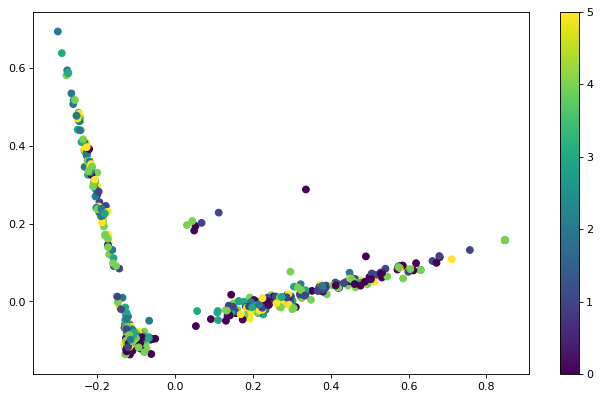

Comparing k-means clusters against the data:
col_0          0   1   2   3   4   5
text_source                         
0            142  20   2  26  13   4
1             47  29   2  22   8   6
2             90   3  22   8   1  10
3             66   8   8  16   2   3
4             94  19  19  23  12  17
5             83   6  17  15   3  10


In [16]:
# Reduce it to two components.
x_pca = PCA(2).fit_transform(X_train)
       
y_pred = KMeans(n_clusters=6).fit_predict(x_pca)    

# Plot the solution.
# l1 = [('Caesar', 'Dracula', 'Iliad', 'Pan', 'Tom', 'Wizard')]
# l2 = [0, 1, 2, 3, 4, 5]

plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_train, label=y_train)
plt.colorbar()
# plt.legend()
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))


**Evaluation:**  Most of the corpora fall into cluster 1; however, there are not clear delineations for each cluster.  An argument could be made that cluster 0 could be most similar to corpus 1, or 'Dracula'.  Similarly, cluster 5 could be seen as most likely sentences from 'Julius Caesar' which is the row labeled 0.

#### K-Means with PCA for visualization - Each color represents a different cluster this time

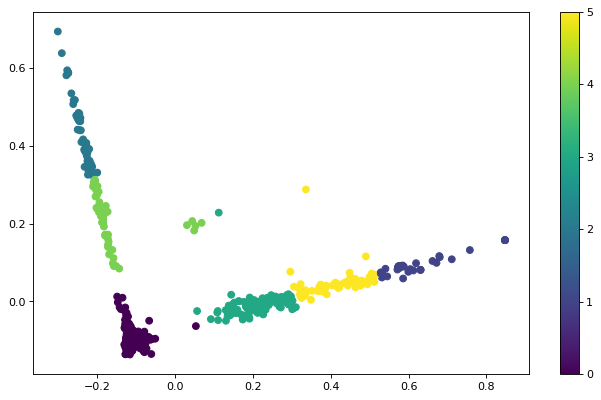

Comparing k-means clusters against the data:
col_0          0   1   2   3   4   5
text_source                         
0            142  13   2  26   4  20
1             47   8   2  22   6  29
2             90   1  22   8  10   3
3             66   2   8  16   3   8
4             94  12  19  23  17  19
5             83   3  17  15  10   6


In [17]:
# Reduce it to two components.
x_pca = PCA(2).fit_transform(X_train)
       
y_pred = KMeans(n_clusters=6).fit_predict(x_pca)    

# Plot the solution.
# l1 = [('Caesar', 'Dracula', 'Iliad', 'Pan', 'Tom', 'Wizard')]
# l2 = [0, 1, 2, 3, 4, 5]

plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_pred)
plt.colorbar()
# plt.legend()
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))

**Evaluation:**  Here the clusters are grouped by color; however, from the crosstab matrix there are no clear clusters assigned to a particular corpus.  Only 2 components were used to create this plot (out of about 3600 total features), so we are asking a lot of these 2 components to yield accrate groupings.

#### K-Means with LSA for visualization   
Latent Semantic Analysis is the process of applying PCA to a tf-idf term-document matrix.  Each color represents a different cluster.

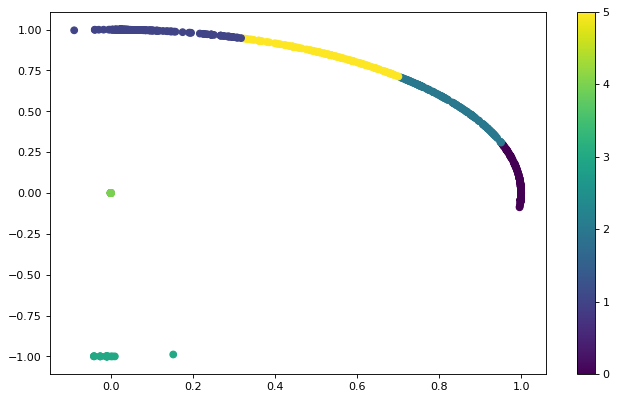

Comparing k-means clusters against the data:
col_0          0   1   2   3   4   5
text_source                         
0            121  10  44  10   1  21
1             61  26  13   0   6   8
2             17  61  22   5   1  28
3             33  22  22   0   8  18
4             73  51  22   4  20  14
5             40  36  27   0   2  29


In [18]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd = TruncatedSVD(2)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train)

# Calculate predicted values.
y_pred = KMeans(n_clusters=6).fit_predict(X_train_lsa)
# print(y_pred[:10])

# Plot the solution.
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred)
plt.colorbar()
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))

**Evaluation:**  This LSA method produces an interesting semi-circular shape.  Once again, the crosstab data does not show clear grouping for any of the corpora.  Perhaps the clearest groupings would be to associate cluster 0 with corpus 0 and cluster 2 with corpus 4 - which is 'Peter Pan'.

#### K-Means Clustering without using PCA or LSA - just using crosstab to possibly identify clusters of data

In [19]:
# Calculate predicted values; setting number of cluster to 6.
y_pred = KMeans(n_clusters=6).fit_predict(X_train)    

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))


Comparing k-means clusters against the data:
col_0         0   1   2   3   4   5
text_source                        
0            84  18  56   4  45   0
1            42   6  59   6   1   0
2            81   4  11  32   6   0
3            69   3  21  10   0   0
4            85   7  54  33   5   0
5            59   3  21  26   0  25


**Evaluation:**  It looks like cluster 2 could be assigned to corpus 1 and cluster 4 to corpus 0.  The groupings, however, look fairly random.

#### Mean Shift with PCA for visualization - Each color represents a different corpus

Number of estimated clusters: 6


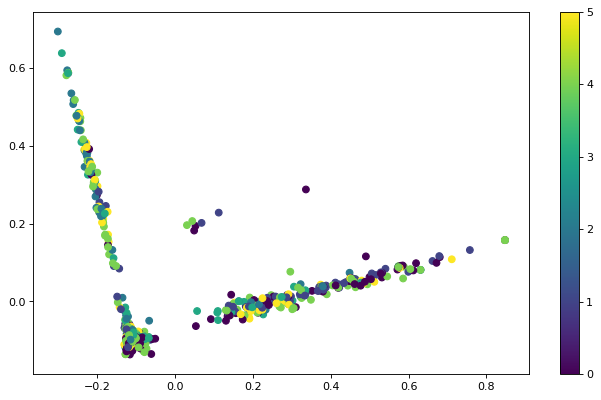

Comparing Mean Shift clusters against the data:
col_0          0   1   2   3  4  5
text_source                       
0            142  47   4  10  2  2
1             49  51   5   7  2  0
2             91  11  31   1  0  0
3             68  23  10   2  0  0
4             97  42  31  12  2  0
5             83  21  27   3  0  0


In [20]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(x_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Plot the solution.
plt.figure(figsize=(10, 6), dpi=80)

# change c= values of text source
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_train)
plt.colorbar()

plt.show()

# Check the solution against the data.
print('Comparing Mean Shift clusters against the data:')
print(pd.crosstab(y_train, labels))

**Evaluation:**  Most of the data points are in cluster 0 this time.  Again the clusters are poorly defined and appear somewhat random.  The Mean Shift method did yield 6 clusters which is exactly equal to the number of corpora represented.  However, it looks like luck was involved due to the random groupings.  

#### Mean Shift with PCA for visualization - Each color represents a different cluster this time

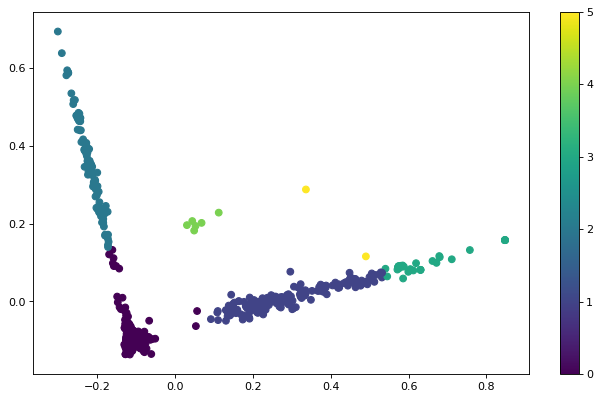

Comparing Mean Shift clusters against the data:
col_0          0   1   2   3  4  5
text_source                       
0            142  47   4  10  2  2
1             49  51   5   7  2  0
2             91  11  31   1  0  0
3             68  23  10   2  0  0
4             97  42  31  12  2  0
5             83  21  27   3  0  0


In [21]:
# Plot the solution.
plt.figure(figsize=(10, 6), dpi=80)

# change c= values of text source
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=labels)
plt.colorbar()

plt.show()

# Check the solution against the data.
print('Comparing Mean Shift clusters against the data:')
print(pd.crosstab(y_train, labels))

**Evaluation:**  Fairly random clusters.  These clusters don't tell us too much.  Again, only using 2 components might be tough to generate relevant groupings.

#### Mean Shift with LSA for visualization   
Latent Semantic Analysis is the process of applying PCA to a tf-idf term-document matrix.  Each color represents a different cluster.

Number of estimated clusters: 5


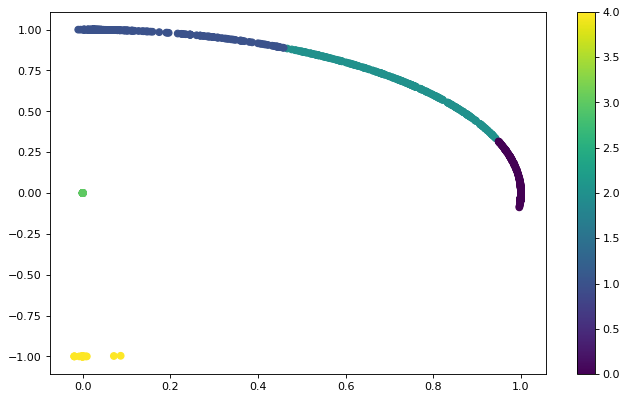

Comparing Mean Shift clusters against the data:
col_0          0   1   2   3   4
text_source                     
0            121  14  61   1  10
1             61  24  20   6   3
2             17  70  42   1   4
3             35  28  32   8   0
4             75  56  29  20   4
5             42  43  47   2   0


In [22]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd = TruncatedSVD(2)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train)

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Plot the solution.
plt.figure(figsize=(10, 6), dpi=80)

# change c= values of text source
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=labels)
plt.colorbar()
plt.show()

# Check the solution against the data.
print('Comparing Mean Shift clusters against the data:')
print(pd.crosstab(y_train, labels))

**Evaluation:**  Very similar to LSA method from K-Means.

#### Mean Shift Clustering without using PCA or LSA - just using crosstab to possibly identify clusters of data

In [23]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Check the solution against the data.
print('Comparing Mean Shift clusters against the data:')
print(pd.crosstab(y_train, labels))

Number of estimated clusters: 1
Comparing Mean Shift clusters against the data:
col_0          0
text_source     
0            207
1            114
2            134
3            103
4            184
5            134


**Evaluation:**  Using the full data, the Mean Shift clustering method yielded only 1 cluster.  This is odd, since there are 6 corpora.

#### Spectral with PCA for visualization - Each color represents a different corpus

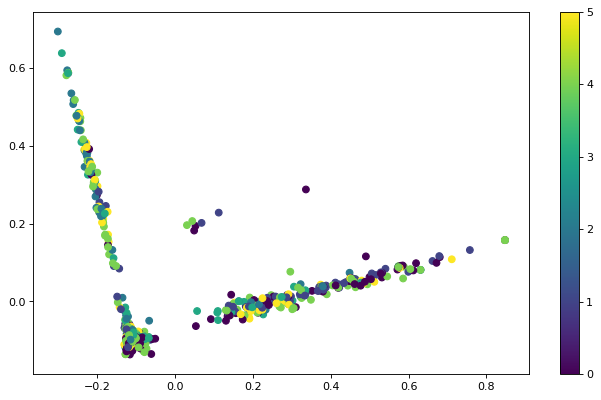

Comparing Spectral clusters against the data:
col_0         0    1   2  3   4   5
text_source                        
0            13  141   4  3   0  46
1             8   45   7  2   2  50
2             1   89  24  0   9  11
3             2   65   8  0   4  24
4            12   93  25  2  10  42
5             3   82  24  0   4  21


In [24]:
from sklearn.cluster import SpectralClustering

# We know we're looking for six clusters.
n_clusters = 6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(x_pca)

# Predicted clusters.
predict = sc.fit_predict(x_pca)

# Graph results.
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_train)
plt.colorbar()
plt.show()

# Check the solution against the data.
print('Comparing Spectral clusters against the data:')
print(pd.crosstab(y_train, predict))

**Evaluation:**  The cluster have a similar shape here as the two previous methods.  From the crosstab results, the clusters don't have an obvious corpus attached to them.  

#### Spectral with PCA for visualization - Each color represents a different cluster this time

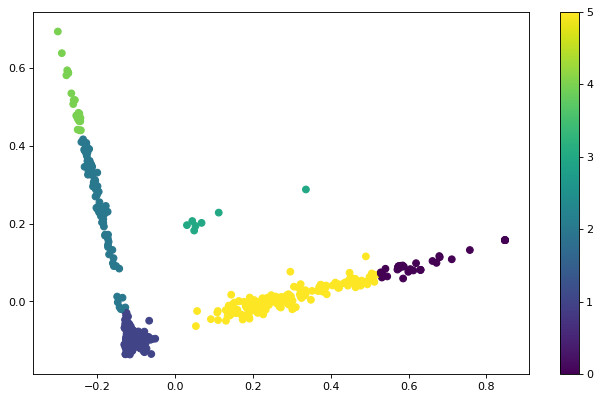

Comparing Spectral clusters against the data:
col_0         0    1   2  3   4   5
text_source                        
0            13  141   4  3   0  46
1             8   45   7  2   2  50
2             1   89  24  0   9  11
3             2   65   8  0   4  24
4            12   93  25  2  10  42
5             3   82  24  0   4  21


In [25]:
# Graph results.
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=predict)
plt.colorbar()
plt.show()

# Check the solution against the data.
print('Comparing Spectral clusters against the data:')
print(pd.crosstab(y_train, predict))

**Evaluation:**  Still tough to separate each corpus into clusters.  Cluster 1 has mainly works from corpus 0, or 'Julius Caesar'.

#### Spectral with LSA for visualization   
Latent Semantic Analysis is the process of applying PCA to a tf-idf term-document matrix.  Each color represents a different cluster.

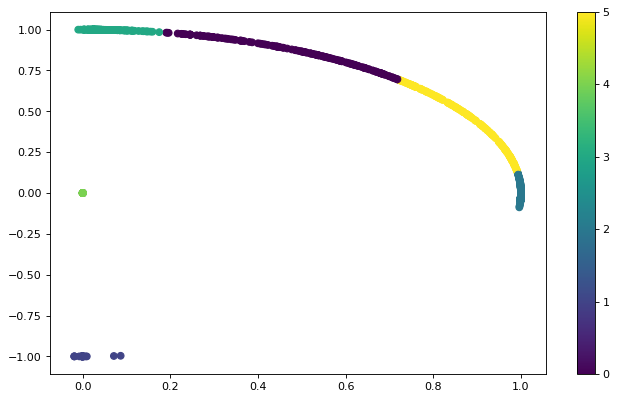

Comparing Spectral clusters against the data:
col_0         0   1   2   3   4   5
text_source                        
0            27  10  91   7   1  71
1            19   3  60  12   6  14
2            31   4  13  60   1  25
3            24   0  28  17   8  26
4            23   4  61  43  20  33
5            34   0  30  33   2  35


In [26]:
# We know we're looking for six clusters.
n_clusters = 6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_lsa)

# Predicted clusters.
predict = sc.fit_predict(X_train_lsa)

# Graph results.
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict)
plt.colorbar()
plt.show()

# Check the solution against the data.
print('Comparing Spectral clusters against the data:')
print(pd.crosstab(y_train, predict))

**Evaluation:**  Again the semi-circular shape with Latent Semantic Analysis.  Each cluster could be grouped in a certain pattern, but not necessarily by the corpus identity.

#### Spectral Clustering without using PCA or LSA - just using crosstab to possibly identify clusters of data

In [27]:
# We know we're looking for six clusters.
n_clusters = 6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(x_pca)

# Predicted clusters.
predict = sc.fit_predict(x_pca)

# Check the solution against the data.
print('Comparing Spectral clusters against the data:')
print(pd.crosstab(y_train, predict))

Comparing Spectral clusters against the data:
col_0         0    1   2   3  4   5
text_source                        
0            46  141   4  13  3   0
1            50   45   7   8  2   2
2            11   89  24   1  0   9
3            24   65   8   2  0   4
4            42   93  25  12  2  10
5            21   82  24   3  0   4


**Evaluation:**  Not real clear cluster groupings.

# Build the models - Supervised Learning
The "text_source" is the dependent variable the models are trying to predict.

#### Random Forest

In [28]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier(n_estimators=100)

train = rfc.fit(X_train, y_train)
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

y_test_pred = rfc.predict(X_test)

print('\nConfusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None))

Training set score: 0.9703196347031964

Test set score: 0.6450511945392492

Confusion Matrix:
[[31  2  3  0 17  1]
 [ 0 19  0  0 10  1]
 [ 5  2 23  0 21  2]
 [ 1  5  1 21  8  1]
 [ 2  1  0  4 64  3]
 [ 0  3  0  1 10 31]]


**Evaluation:**  The accuracy score of 65% is not bad considering the ground truth accuracy (or random guessing) is 17%.

#### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

y_test_pred = lr.predict(X_test)

print('\nConfusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None))

C:\Users\Fred\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Fred\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(876, 3614) (876,)
Training set score: 0.8641552511415526

Test set score: 0.658703071672355

Confusion Matrix:
[[44  0  3  0  7  0]
 [ 8 15  1  1  4  1]
 [13  2 32  0  6  0]
 [ 4  2  3 17 10  1]
 [13  4  2  1 53  1]
 [ 4  4  2  1  2 32]]


**Evaluation:**  Again, an accuracy score of 66%.  Most of the correctly labeled data points fall on the main diagonal of the confusion matrix and there is a fairly even distribution of points in the upper and lower traingles.

#### Gradient Boosting

In [30]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

y_test_pred = clf.predict(X_test)

print('\nConfusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None))

Training set score: 0.9406392694063926

Test set score: 0.6040955631399317

Confusion Matrix:
[[41  3  3  0  5  2]
 [ 7 19  0  1  2  1]
 [22  1 25  2  3  0]
 [ 4  6  2 20  4  1]
 [20  6  0  2 45  1]
 [ 7  5  0  0  6 27]]


**Evaluation:**  An accuracy of 60% for the gradient boosting algorithm.  Very similar to the previous modeling scores.

#### Support Vector Machines

In [31]:
from sklearn.svm import SVC

sv_c = SVC(gamma='auto', kernel='linear', class_weight='balanced')
train = sv_c.fit(X_train, y_train)

print('Training set score:', sv_c.score(X_train, y_train))
print('\nTest set score:', sv_c.score(X_test, y_test))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

y_test_pred = sv_c.predict(X_test)

print('\nConfusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None))

Training set score: 0.928082191780822

Test set score: 0.6450511945392492

Confusion Matrix:
[[33  4  4  0 13  0]
 [ 1 18  1  4  6  0]
 [ 2  1 37  4  8  1]
 [ 1  6  4 21  3  2]
 [ 3  7  4  6 49  5]
 [ 0  5  3  2  4 31]]


**Evaluation:**  An accuracy score of 65% for support vector machines; very similar to the previous models.  All models performed consistently agains the test data - correctly classifying each test (or sentence) around 65% of the time.  

# Evaluation and Conclusion  

**Unsupervised Learning / Clustering:**  

Three different methods were used to identify groupings or cluster of the various corpora - K-Means, Mean Shift, and Spectral.  Withing each of these methods, PCA was used to create a visual representation - 1 plot using the corpus as the color definitions, the second plot using the algorithm generated cluster for their color definitions.  Since the grouping were not clearly defined using these visualizations and their crosstab values, the LSA method was then tried to again reduce the number of component to 2 in order to visualize the clusters in 2-D format.  The LSA method produced an interesting semi-circular graph, but did not necessarily produce useful clusters.  The clusters might be relevant in other ways, but they did not group well according to the specific corpus.  Finally, using K-Means, Mean Shift and Spectral clustering methods with the full amount of data (not just 2 components), the results show that the clustering models build here, do not really group the corpus into well defined clusters.

However, the supervised learning techniques to predict which sentence belongs to which corpus yielded much more inspiring results.

**Supervised Learning:**  

All of the models were evaluated using at most about 14% of the data.  The initial accuracy scores (for test data set) for the 4 models are as follows:  

- Random Forest:  0.65    
- Logistic Regression:  0.66  
- Gradient Boosting:  0.60  
- Support Vector Machines:  0.65  

Adjusting the number of 'most_common' words in bag of words from 2000 to 500 and requiring words to appear at least 4 times instead of twice in term frequency improved the accuracy scores by a few percentage points.

With the additional feature of **'number of words in each sentence' and 'parts of speach'**, the supervised accuracy scores fell from 3 - 10 percent.  Adding these features appears to have added noise to the data - therefore these features are commented out of the final solution.

The data looks balanced from the Confusion Matrix values; however, the Confusion Matrix for the Support Vector Machines model yielded 0 True Negatives and 0 False Negatives - prior to changing the kernal from 'rbf' to 'linear'.  After this change the CM became more balanced and much more accurate.  

Final Conclusion:  The hope of this notebook was to create clustering models that clearly defined each corpus into a specific cluster as generated by each of the 3 algorithms tested.  Another aspiration was to create supervised learning models that were good predictors for determing the corpus of a randomly chosen sentence.  The clustering methods fell short of expectations, so more study is needed to perhaps create better features and/or create better models.  The supervised techniques, however, produce fairly accurate results relative to the amount of data used for each corpus and relative to the ground truth accuracy rate of 17%. 
